In [21]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../VT_SNN/")

In [22]:
import torch
import numpy as np
import slayerSNN as snn
from pathlib import Path
import logging
from snn_models.baseline_snn import SlayerMLP
from snn_models.multimodal_snn import EncoderTact
from torch.utils.data import DataLoader
from dataset import ViTacDataset, ViTacMMDataset

In [23]:
fname='../aux_rests/mm_old_loss_wo'

In [24]:
class FLAGS():
    def __init__(self):
        self.data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN_new/'
        self.batch_size = 8
        self.sample_file = 2
        self.lr = 0.001
        self.epochs = 500
        self.output_size = 20
        self.theta = 10
        self.tauRho = 1
        self.tsample= 325
        self.tsr_stop = 325
        self.sc_true = 150
        self.sc_false = 5
        self.hidden_size = 32
args = FLAGS()

In [25]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": args.theta, # activation threshold
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": args.tsample, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 325,
            },
            "tgtSpikeCount": {True: args.sc_true, False: args.sc_false},
        }
    },
}

In [26]:
output_size = args.output_size # 20

train_dataset = ViTacMMDataset(
    path=args.data_dir, sample_file=f"train_80_20_{args.sample_file}.txt", output_size=args.output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)
test_dataset = ViTacMMDataset(
    path=args.data_dir, sample_file=f"test_80_20_{args.sample_file}.txt", output_size=args.output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)

In [27]:
len(train_dataset)

240

In [28]:
a,b,c, d = test_dataset[0]
a.shape, b.shape

(torch.Size([156, 1, 1, 325]), torch.Size([2, 63, 50, 325]))

In [29]:
torch.unique(a), torch.unique(b)

(tensor([0., 1.]), tensor([0., 1.]))

In [30]:
class EncoderVis(torch.nn.Module):
    def __init__(self, netParams, output_size):
        super(EncoderVis, self).__init__()
        self.slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.fc1   = self.slayer.dense((50, 63, 2), output_size)
    def forward(self, downsampled):
        #spikeLayer1 = self.slayer.spike(self.slayer.psp(downsampled)) # 32, 32, 16
        spikeLayer5 = self.slayer.spike(self.fc1(self.slayer.psp(downsampled))) #  10
        #self.spike_trains = [spikeLayer1]
        return spikeLayer5

In [31]:
class SlayerMM(torch.nn.Module):
    def __init__(self, netParams, output_size):
        super(SlayerMM, self).__init__()
        slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.tactile = EncoderTact(netParams, 50)
        self.vision = EncoderVis(netParams, 10)
        self.slayer = slayer
        self.fc1   = slayer.dense(60, output_size)

    def forward(self, spikeInputTact, spikeInputVis):
        spikeLayer1 = self.tactile(spikeInputTact)
        spikeLayer2 = self.vision(spikeInputVis)
        spikeAll = torch.cat([spikeLayer1, spikeLayer2], dim=1)
        #self.spike_trains = [spikeAll] + self.tactile.spike_trains + self.vision.spike_trains

        out = self.slayer.spike(self.slayer.psp(self.fc1(spikeAll)))
        return out

In [32]:
device = torch.device("cuda:1")
net = SlayerMM(params, args.output_size).to(device)

error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=args.lr, weight_decay=0.5
)

In [33]:
net

SlayerMM(
  (tactile): EncoderTact(
    (slayer): spikeLayer()
    (fc1): _denseLayer(156, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  )
  (vision): EncoderVis(
    (slayer): spikeLayer()
    (fc1): _denseLayer(2, 10, kernel_size=(63, 50, 1), stride=(1, 1, 1), bias=False)
  )
  (slayer): spikeLayer()
  (fc1): _denseLayer(60, 20, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
)

In [34]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(1, args.epochs+1):
    tr_correct = 0
    btr_loss = 0
    net.train()
    for i, (tac, vis, target, label) in enumerate(train_loader):
        tac = tac.to(device)
        vis = vis.to(device)
        target = target.to(device)
        output = net.forward(tac, vis)
        tr_correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        loss = error.numSpikes(output, target)
        btr_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Evaluate
    te_correct = 0
    bte_loss = 0
    net.eval()
    with torch.no_grad():
        for i, (tac, vis, target, label) in enumerate(test_loader):
            tac = tac.to(device)
            vis = vis.to(device)
            target = target.to(device)
            output = net.forward( tac, vis)
            te_correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            loss = error.numSpikes(output, target)
            bte_loss += loss.item()

    if epoch%10 == 0:
        print('Epoch:', epoch)    
        print('Accs (train, test):', tr_correct/len(train_dataset), te_correct/len(test_dataset))
        print('Loss (train, test):', btr_loss/len(train_dataset), bte_loss/len(test_dataset))
    
    train_loss.append( btr_loss/len(train_dataset) )
    test_loss.append( bte_loss/len(test_dataset) )
    train_acc.append( tr_correct/len(train_dataset) )
    test_acc.append( te_correct/len(test_dataset) )

Epoch: 10
Accs (train, test): 0.5125 0.3
Loss (train, test): 23.77527707417806 27.711181131998696
Epoch: 20
Accs (train, test): 0.7791666666666667 0.4666666666666667
Loss (train, test): 15.592039362589519 22.74202651977539
Epoch: 30
Accs (train, test): 0.9208333333333333 0.55
Loss (train, test): 9.72762877146403 19.623386255900066
Epoch: 40
Accs (train, test): 0.9875 0.7
Loss (train, test): 6.087551514307658 17.551616923014322
Epoch: 50
Accs (train, test): 0.9833333333333333 0.65
Loss (train, test): 4.4482630332310995 17.8219243367513
Epoch: 60
Accs (train, test): 1.0 0.6833333333333333
Loss (train, test): 2.7435898502667744 16.354641723632813
Epoch: 70
Accs (train, test): 1.0 0.6666666666666666
Loss (train, test): 2.020910221338272 16.01023152669271
Epoch: 80
Accs (train, test): 1.0 0.6666666666666666
Loss (train, test): 2.042141044139862 15.12200050354004
Epoch: 90
Accs (train, test): 1.0 0.65
Loss (train, test): 0.9867820103963216 16.334180768330892
Epoch: 100
Accs (train, test): 1.

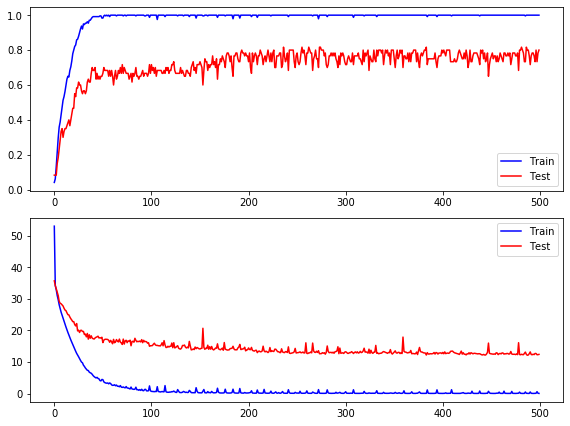

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,figsize=(8,6))
ax[0].plot(train_acc, 'b')
ax[0].plot(test_acc, 'r')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_loss, 'b')
ax[1].plot(test_loss, 'r')
ax[1].legend(['Train', 'Test'])
plt.tight_layout(True)
plt.show()

In [36]:
import pickle
pickle.dump([train_acc, test_acc, train_loss, test_loss], open(fname + '.pk', 'wb'))

In [37]:
torch.save(net.state_dict(), fname+'.pt')